In [2]:
import math
import random
from datetime import date
import warnings
from typing import List, Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from mlforecast import MLForecast
from mlforecast.lag_transforms import ExpandingMean, RollingMean, ExpandingStd, ExponentiallyWeightedMean
from mlforecast.target_transforms import Differences, LocalStandardScaler, GlobalSklearnTransformer
from mlforecast.feature_engineering import transform_exog
from utilsforecast.feature_engineering import fourier, trend, pipeline
from mlforecast.utils import PredictionIntervals

from numba import njit
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, RobustScaler, FunctionTransformer, OneHotEncoder, TargetEncoder

from sklearn.linear_model import LinearRegression
from window_ops.shift import shift_array

from xgboost import XGBRegressor
from catboost import CatBoostRegressor


# Suppress warnings
warnings.filterwarnings('ignore')

## Import MLForecast_Evaluator and helper functions:

In [3]:
import sys
import os

# Get the parent directory
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# Add the parent directory to the system path
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# Now you can import the Evaluator class
from fao_utils import MLForecast_Evaluator, query_country, load_fao_table

# Load data and preprocess it

In [4]:
data = pd.read_parquet(r'../data/FAOSTAT/clean_data/all_tables_processed/full_country_dataset_v3_TOTALS.parquet')

### Select only World and continents

In [5]:
selected_regions = [5000, 5100, 5203, 5207, 5300, 5400, 5500]
data = data[data['Area Code'].isin(selected_regions)]
data = data[data['Year'] > 1990]

In [6]:
data.Area.unique()

array(['World', 'Africa', 'Northern America', 'South America', 'Asia',
       'Europe', 'Oceania'], dtype=object)

### Load population table

In [7]:
projections = load_fao_table(path='../data/FAOSTAT/all_raw', table_number=58)

In [8]:
# Also select only continents and "world" region
projections = projections[projections['Area Code'].isin(selected_regions)] 

In [9]:
projections = projections[projections['Element'] == 'Total Population - Both sexes']

In [10]:
selected_columns = ['Area Code', 'Area', 'Year', 'Value']
projections = projections[selected_columns].rename(columns={'Value': 'population_1000s'})

### Select FORECASTING TARGET:

Por ahora a modo de ejemplo, voy a utilizar "Total_Energy_Emissions_(CO2)_kt"

In [11]:
target = "TOTAL_TOTAL_EMISSIONS_(CO2eq)_kt"

In [12]:
# Will test on "Total_Energy_Emissions_(CO2)_kt"
data = data.rename(columns={"Area": "unique_id", "Year": "ds", 
                            target: "y",
                            "Population_-_Est._&_Proj._Total_Population_-_Both_sexes_1000_No": "population_1000s"})

cols = ["unique_id", "ds", "y", "population_1000s"]
data = data[cols].dropna()

In [13]:
# Will test on "Total_Energy_Emissions_(CO2)_kt"
projections = projections.rename(columns={"Area": "unique_id", "Year": "ds"})

cols = ["unique_id", "ds", "population_1000s"]
projections = projections[cols].dropna()

### Train/Validation Split

In [14]:
train_index = sorted(list(data["ds"].unique()))[:-5]
valid_index = sorted(list(data["ds"].unique()))[-5:] # Last 5 years for validation

In [15]:
train = data.loc[data['ds'].isin(train_index)]
valid = data.loc[data['ds'].isin(valid_index)]
valid.sample(5)

,unique_id,ds,y,population_1000s
10246,World,2020,1.331328e+07,7840952.880
10749,Asia,2019,4.720669e+06,4628967.397
10247,World,2021,1.207747e+07,7909295.146
10581,Northern America,2019,9.858395e+05,371967.923
11003,Europe,2021,1.238758e+06,745173.770


In [16]:
# XGBRegressor
xgb = XGBRegressor(
    n_estimators=100,
    max_depth=5,
    reg_lambda=1,
    reg_alpha=1,
    random_state=42
)

# List of models
models = [xgb]

## Create target lags and lag transformations

In [17]:
@njit
def ratio_over_previous(x, offset=1):
    """Computes the ratio between the current value and its `offset` lag"""
    return x / shift_array(x, offset=offset)

@njit
def diff_over_previous(x, offset=1):
    """Computes the difference between the current value and its `offset` lag"""
    return x - shift_array(x, offset=offset)

sk_log1p = FunctionTransformer(func=np.log1p, inverse_func=np.expm1)

fcst = MLForecast(
    models=models,
    freq=1,
    lags=[1,2,3],
    lag_transforms={
        1: [
            RollingMean(window_size=3),
            ExpandingMean(),
            ExponentiallyWeightedMean(alpha=0.7), #Higher alpha gives more importance to recent years
            ExpandingStd(),
            ratio_over_previous, (ratio_over_previous, 2),
            diff_over_previous, (diff_over_previous, 2)
            ],
        2: [
            RollingMean(window_size=3),
            ExpandingMean(),
            ExponentiallyWeightedMean(alpha=0.7), #Higher alpha gives more importance to recent years
            ExpandingStd(),
            ratio_over_previous, (ratio_over_previous, 2),
            diff_over_previous, (diff_over_previous, 2)
            ],
        3: [
            RollingMean(window_size=3),
            ExpandingMean(),
            ExponentiallyWeightedMean(alpha=0.8), #Higher alpha gives more importance to recent years
            ExpandingStd(),
            # ratio_over_previous, (ratio_over_previous, 2),
            # diff_over_previous, (diff_over_previous, 2)
            ],
    },
    # target_transforms=[GlobalSklearnTransformer(sk_log1p)],
    target_transforms=[GlobalSklearnTransformer(sk_log1p), Differences([1])],
    # target_transforms=[Differences([1])],

    num_threads=6
)

We are predicting target log differences:

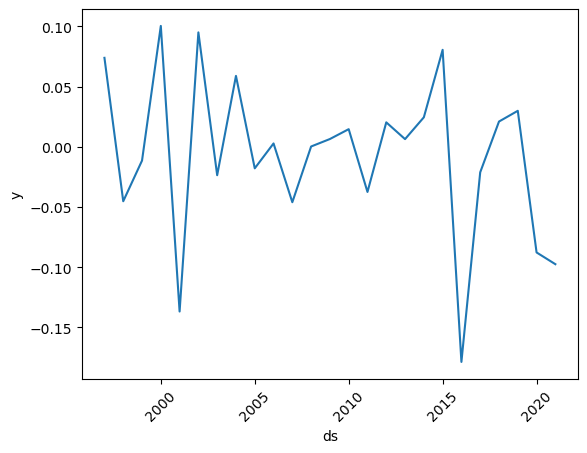

,unique_id,ds,y,population_1000s,lag1,lag2,lag3,rolling_mean_lag1_window_size3,expanding_mean_lag1,exponentially_weighted_mean_lag1_alpha0.7,...,exponentially_weighted_mean_lag2_alpha0.7,expanding_std_lag2,ratio_over_previous_lag2,ratio_over_previous_lag2_offset2,diff_over_previous_lag2,diff_over_previous_lag2_offset2,rolling_mean_lag3_window_size3,expanding_mean_lag3,exponentially_weighted_mean_lag3_alpha0.8,expanding_std_lag3
10223,World,1997,0.073962,5906481.265,0.053636,-0.080048,0.073225,0.015604,0.013422,0.025456,...,-0.040298,0.064306,-1.093178,15.184804,-0.153274,-0.074777,0.031174,0.031174,0.058760,0.039548
10224,World,1998,-0.045153,5987312.479,0.073962,0.053636,-0.080048,0.015850,0.023512,0.059410,...,0.025456,0.060057,-0.670048,0.732481,0.133685,-0.019589,-0.004032,0.003369,-0.052287,0.064306
10225,World,1999,-0.011384,6067758.458,-0.045153,0.073962,0.053636,0.027482,0.013703,-0.013784,...,0.059410,0.059130,1.378949,-0.923962,0.020325,0.154010,0.015604,0.013422,0.032452,0.060057
10226,World,2000,0.100463,6148898.973,-0.011384,-0.045153,0.073962,0.005808,0.010567,-0.012104,...,-0.013784,0.059893,-0.610494,-0.841840,-0.119115,-0.098789,0.015850,0.023512,0.065660,0.059130
10227,World,2001,-0.136730,6230746.982,0.100463,-0.011384,-0.045153,0.014642,0.020555,0.066693,...,-0.012104,0.056155,0.252123,-0.153920,0.033769,-0.085346,0.027482,0.013703,-0.022991,0.059893


In [18]:
transformed_data = fcst.preprocess(data, static_features=[])
query_country(transformed_data, unique_id ="World", target_col="y").head()

In [19]:
# Correlation to target
transformed_data.drop(columns=['unique_id', 'ds']).corr()['y'].sort_values(ascending=False)

y                                            1.000000
diff_over_previous_lag2_offset2              0.164207
ratio_over_previous_lag1                     0.085309
ratio_over_previous_lag2_offset2             0.079593
rolling_mean_lag3_window_size3               0.076162
exponentially_weighted_mean_lag2_alpha0.7    0.066662
lag2                                         0.059564
expanding_mean_lag2                          0.051839
lag3                                         0.039197
ratio_over_previous_lag1_offset2             0.018417
exponentially_weighted_mean_lag3_alpha0.8    0.015658
diff_over_previous_lag2                      0.012283
expanding_mean_lag3                         -0.006198
population_1000s                            -0.009776
ratio_over_previous_lag2                    -0.037586
rolling_mean_lag2_window_size3              -0.050546
expanding_std_lag3                          -0.065516
expanding_std_lag2                          -0.068898
expanding_std_lag1          

# Train and evaluate

In [20]:
# train = train.drop("population_1000s", axis=1)
fcst.fit(train, fitted=True, static_features=[],
    prediction_intervals=PredictionIntervals(n_windows=3, h=5, method="conformal_distribution"))

MLForecast(models=[XGBRegressor], freq=1, lag_features=['lag1', 'lag2', 'lag3', 'rolling_mean_lag1_window_size3', 'expanding_mean_lag1', 'exponentially_weighted_mean_lag1_alpha0.7', 'expanding_std_lag1', 'ratio_over_previous_lag1', 'ratio_over_previous_lag1_offset2', 'diff_over_previous_lag1', 'diff_over_previous_lag1_offset2', 'rolling_mean_lag2_window_size3', 'expanding_mean_lag2', 'exponentially_weighted_mean_lag2_alpha0.7', 'expanding_std_lag2', 'ratio_over_previous_lag2', 'ratio_over_previous_lag2_offset2', 'diff_over_previous_lag2', 'diff_over_previous_lag2_offset2', 'rolling_mean_lag3_window_size3', 'expanding_mean_lag3', 'exponentially_weighted_mean_lag3_alpha0.8', 'expanding_std_lag3'], date_features=[], num_threads=6)

## Create future df with forecast population for prediction

In [21]:
future_df = pd.concat([valid, projections]).drop('y', axis=1)
future_df = valid.drop('y', axis=1)
future_df.head()

,unique_id,ds,population_1000s
10243,World,2017,7599822.416
10244,World,2018,7683789.830
10245,World,2019,7764951.042
10246,World,2020,7840952.880
10247,World,2021,7909295.146


Plots if I include 1990:
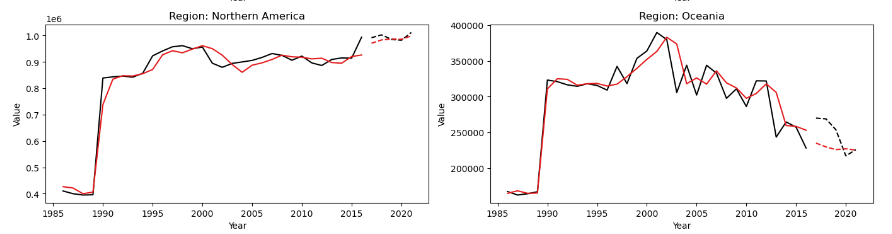

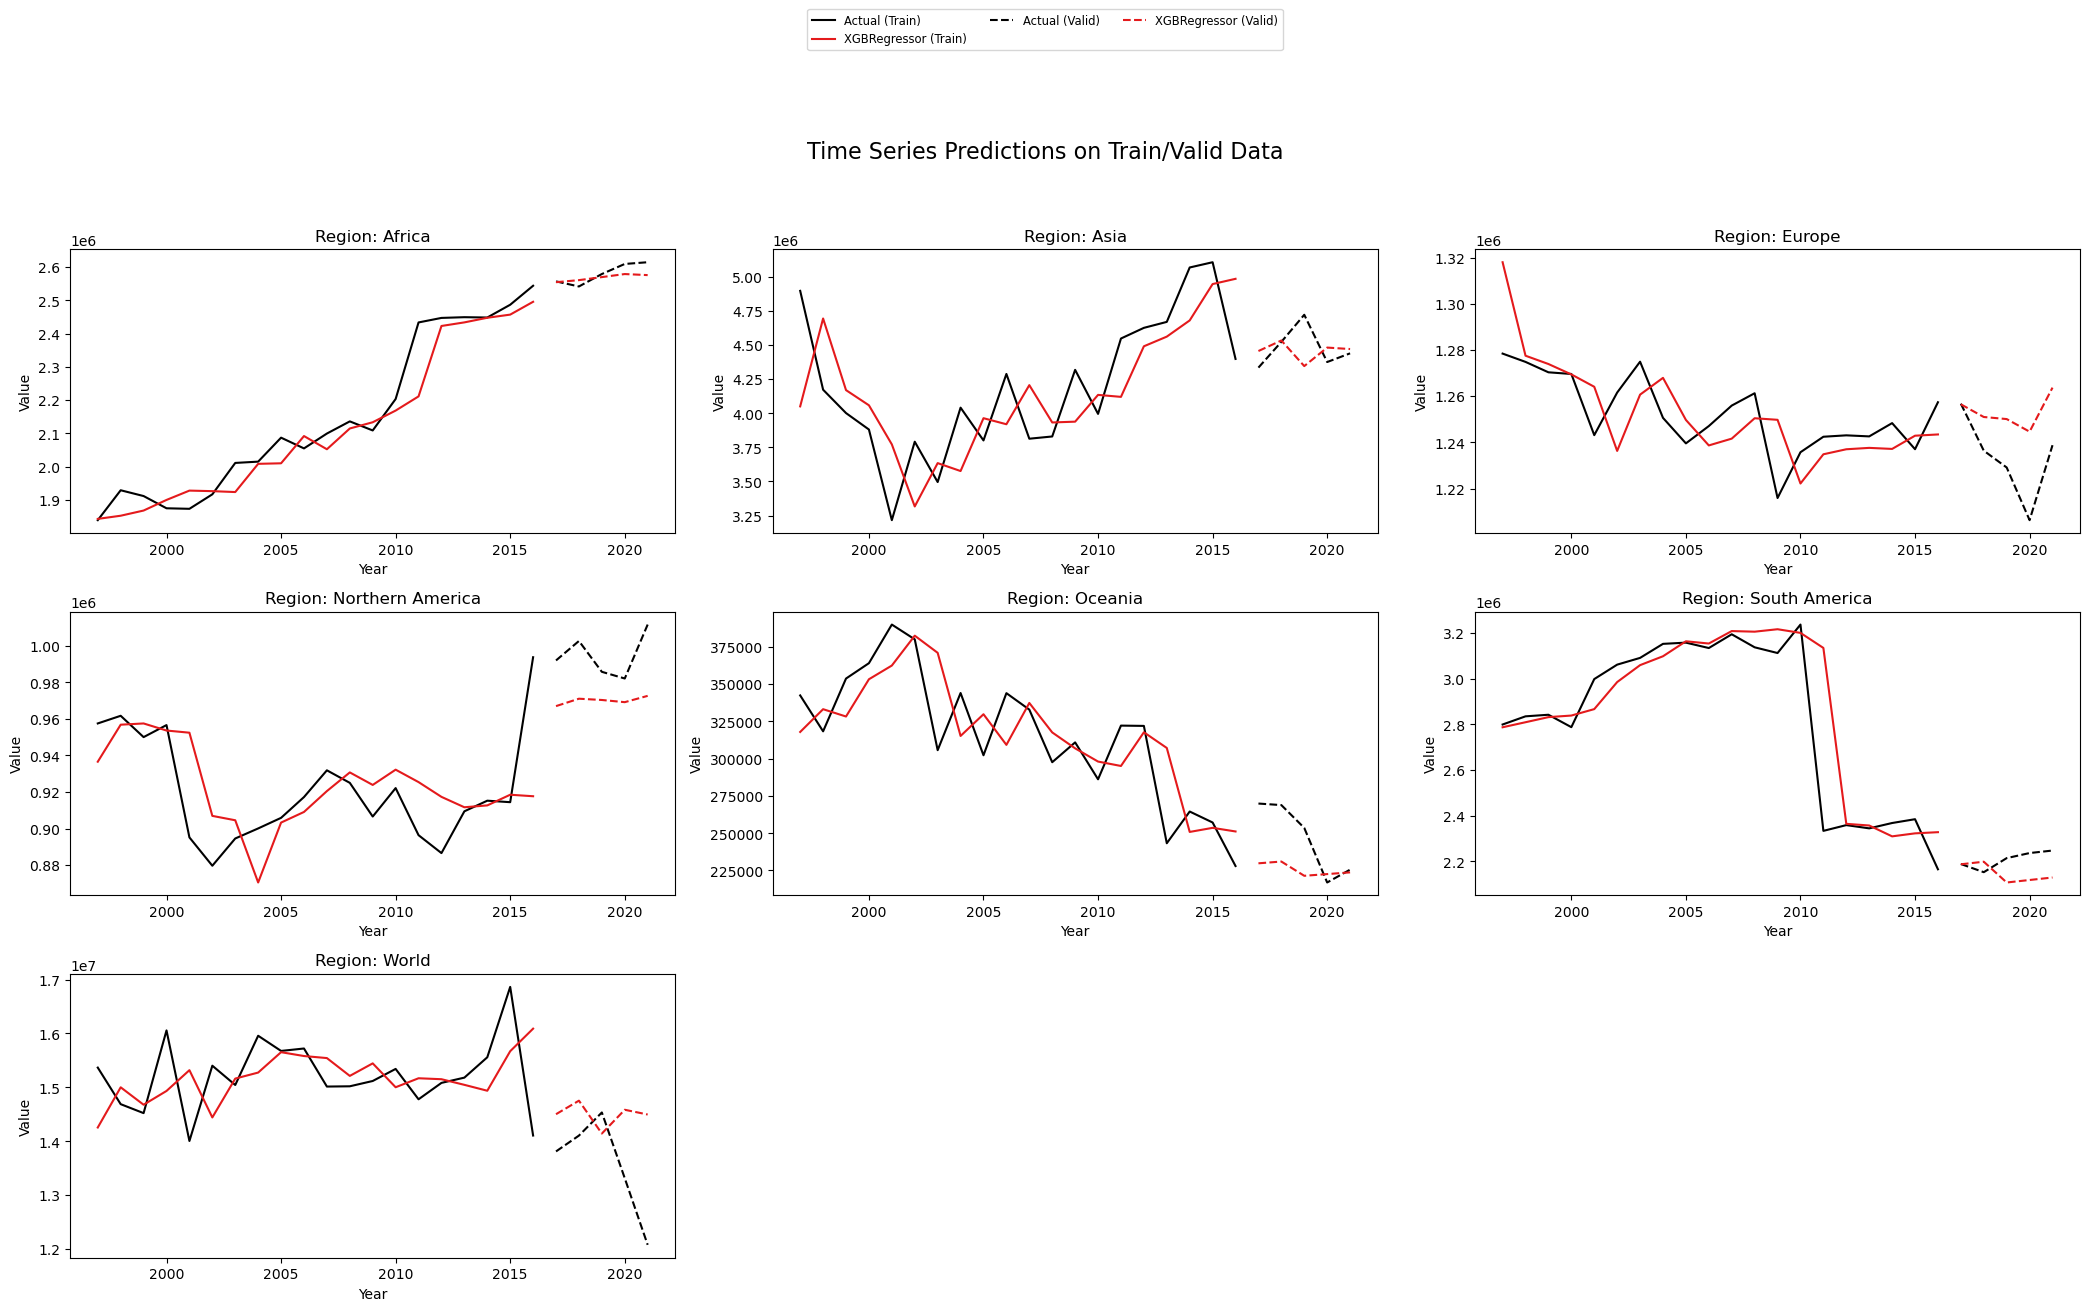

MEAN MAPE_VALID = 4.08%

Model with lowest MAPE validation is XGBRegressor with MAPE = 4.08%

              MAPE_train  MAPE_valid
XGBRegressor    0.039506    0.040813


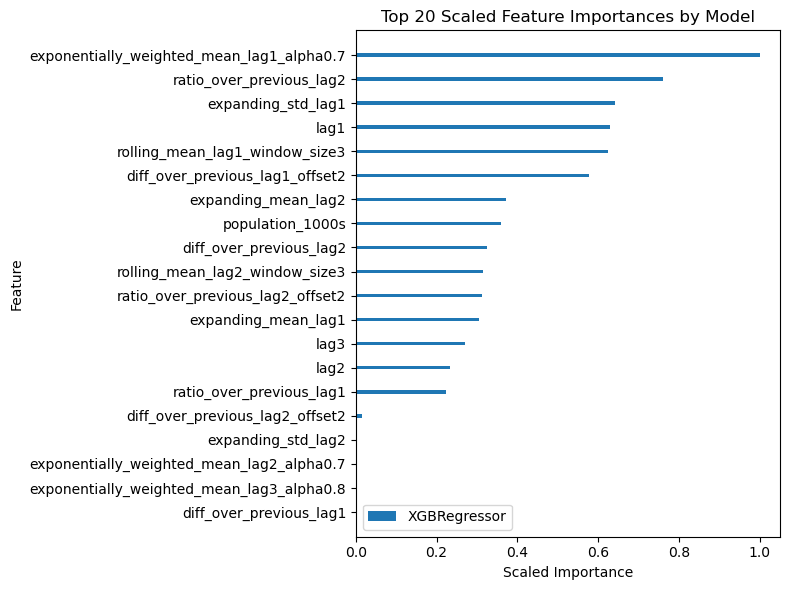

In [22]:
evaluator = MLForecast_Evaluator(fcst, valid, future_df, h=5)

# Plot time series
evaluator.plot_time_series()  # If n_samples is not specified, all time series are plotted

# Calculate and print metrics
evaluator.calculate_metrics()

# Plot feature importances sorted by the average importance
evaluator.plot_feature_importances()

# Predict up to 2030 with full train

In [23]:
future_df_2030 = projections[projections['ds'] <= 2030]
future_df_2030.shape

(567, 3)

In [24]:
full_train = pd.concat([train, valid])

fcst.fit(full_train, fitted=True, static_features=[],
    prediction_intervals=PredictionIntervals(n_windows=3, h=9, method="conformal_distribution"))

MLForecast(models=[XGBRegressor], freq=1, lag_features=['lag1', 'lag2', 'lag3', 'rolling_mean_lag1_window_size3', 'expanding_mean_lag1', 'exponentially_weighted_mean_lag1_alpha0.7', 'expanding_std_lag1', 'ratio_over_previous_lag1', 'ratio_over_previous_lag1_offset2', 'diff_over_previous_lag1', 'diff_over_previous_lag1_offset2', 'rolling_mean_lag2_window_size3', 'expanding_mean_lag2', 'exponentially_weighted_mean_lag2_alpha0.7', 'expanding_std_lag2', 'ratio_over_previous_lag2', 'ratio_over_previous_lag2_offset2', 'diff_over_previous_lag2', 'diff_over_previous_lag2_offset2', 'rolling_mean_lag3_window_size3', 'expanding_mean_lag3', 'exponentially_weighted_mean_lag3_alpha0.8', 'expanding_std_lag3'], date_features=[], num_threads=6)

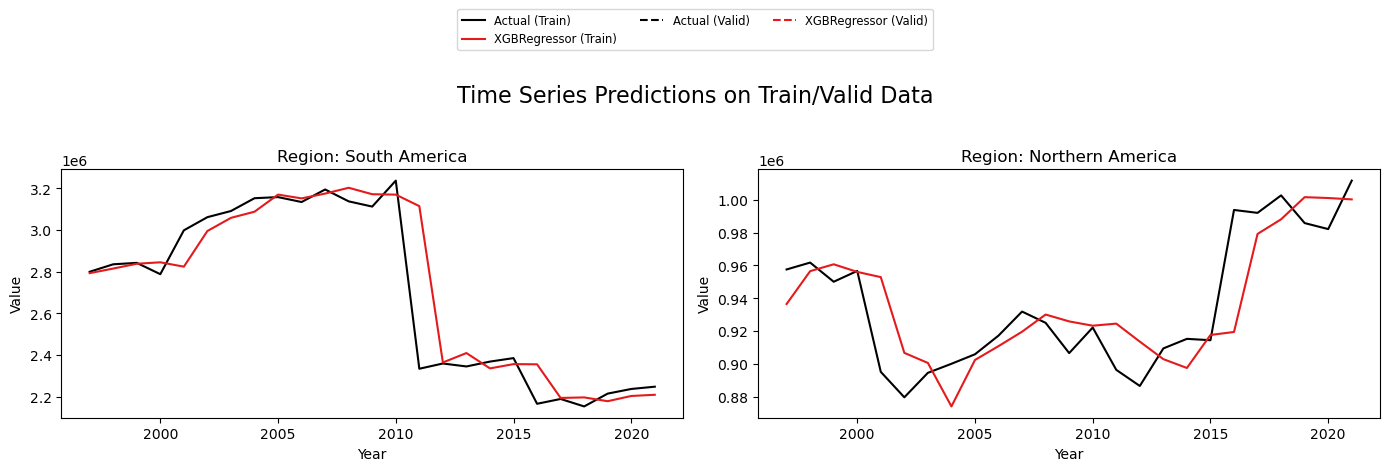

In [25]:
evaluator = MLForecast_Evaluator(fcst, valid, future_df_2030, h=9)

# Plot feature importances sorted by the average importance
evaluator.plot_time_series(n_samples=2)

In [26]:
preds_2030 = fcst.predict(h=9, X_df=future_df_2030, level=[60,70,80,90])
preds_2030

,unique_id,ds,XGBRegressor,XGBRegressor-lo-90,XGBRegressor-lo-80,XGBRegressor-lo-70,XGBRegressor-lo-60,XGBRegressor-hi-60,XGBRegressor-hi-70,XGBRegressor-hi-80,XGBRegressor-hi-90
0,Africa,2022,2.628704e+06,2.617897e+06,2.620206e+06,2.622515e+06,2.624824e+06,2.632585e+06,2.634894e+06,2.637203e+06,2.639512e+06
1,Africa,2023,2.643128e+06,2.577066e+06,2.586935e+06,2.596803e+06,2.606671e+06,2.679584e+06,2.689452e+06,2.699321e+06,2.709189e+06
2,Africa,2024,2.638000e+06,2.595368e+06,2.596384e+06,2.597401e+06,2.598418e+06,2.677582e+06,2.678599e+06,2.679615e+06,2.680632e+06
3,Africa,2025,2.644836e+06,2.549403e+06,2.550632e+06,2.551861e+06,2.553090e+06,2.736582e+06,2.737811e+06,2.739040e+06,2.740270e+06
4,Africa,2026,2.651690e+06,2.530615e+06,2.534392e+06,2.538168e+06,2.541945e+06,2.761435e+06,2.765212e+06,2.768988e+06,2.772765e+06
...,...,...,...,...,...,...,...,...,...,...,...
58,World,2026,1.178702e+07,1.080051e+07,1.108564e+07,1.137078e+07,1.165592e+07,1.191812e+07,1.220325e+07,1.248839e+07,1.277352e+07
59,World,2027,1.174035e+07,1.044325e+07,1.054968e+07,1.065611e+07,1.076254e+07,1.271816e+07,1.282459e+07,1.293102e+07,1.303745e+07
60,World,2028,1.175734e+07,1.113389e+07,1.115874e+07,1.118358e+07,1.120843e+07,1.230625e+07,1.233109e+07,1.235594e+07,1.238078e+07
61,World,2029,1.158721e+07,1.007347e+07,1.032845e+07,1.058343e+07,1.083841e+07,1.233601e+07,1.259099e+07,1.284597e+07,1.310095e+07


In [27]:
def plot_predictions_with_ci(historical_data, forecast_data, 
                             date_col='ds', actual_col='y', 
                             model='XGBRegressor',
                             ci='80',
                             ci2=None,
                             log_y = False,
                             target='Target',
                             region='World'):
    """
    Create a plot of historical data, forecasts, and confidence interval(s).
    
    Parameters:
    - historical_data (pd.DataFrame): DataFrame containing historical data
    - forecast_data (pd.DataFrame): DataFrame containing forecast data and CI
    - date_col (str): Name of the date column
    - actual_col (str): Name of the column with actual values
    - model (str): Name of the model used for predictions
    - ci (str): First confidence interval percentage (e.g., '80' for 80% CI)
    - ci2 (str, optional): Second confidence interval percentage (e.g., '60' for 60% CI)
    - target (str): Name of the target variable
    - region (str): Name of the region being forecasted
    """
    
    ci_low_col = f"{model}-lo-{ci}"
    ci_high_col = f"{model}-hi-{ci}"
    ci_label = f"{ci}% Confidence Interval"

    plt.figure(figsize=(6, 4))
    
    # Plot actual values
    sns.lineplot(x=date_col, y=actual_col, data=historical_data, label="Actual", color='black')
    
    # Plot predictions
    sns.lineplot(x=date_col, y=model, data=forecast_data, label="Prediction", color='darkred')
    
    # Plot first confidence interval as shaded area
    plt.fill_between(forecast_data[date_col], 
                     forecast_data[ci_low_col], 
                     forecast_data[ci_high_col], 
                     alpha=0.3, label=ci_label, color='red')
    
    # Plot second confidence interval if provided
    if ci2:
        ci2_low_col = f"{model}-lo-{ci2}"
        ci2_high_col = f"{model}-hi-{ci2}"
        ci2_label = f"{ci2}% Confidence Interval"
        plt.fill_between(forecast_data[date_col], 
                         forecast_data[ci2_low_col], 
                         forecast_data[ci2_high_col], 
                         alpha=0.15, label=ci2_label, color='blue')
    
    # Customize the plot
    plt.title(f"{target} Predictions for {region}")
    plt.xlabel("Year")
    plt.ylabel(target)
    if log_y:
        plt.yscale('log')
    plt.legend(loc='upper left')
    
     # Ensure the directory exists
    os.makedirs("../plots/forecasts", exist_ok=True)
    
    # Save the plot
    plt.savefig(f"../plots/forecasts/{target}_predictions_{region}.png", dpi=300, bbox_inches='tight')
    
    # Show the plot
    plt.tight_layout()
    plt.show()
    
    print(f"Plot saved as ../plots/forecasts/{target}_predictions_{region}.png")

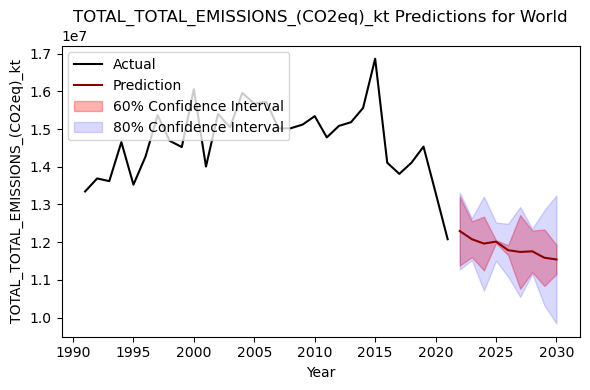

Plot saved as ../plots/forecasts/TOTAL_TOTAL_EMISSIONS_(CO2eq)_kt_predictions_World.png


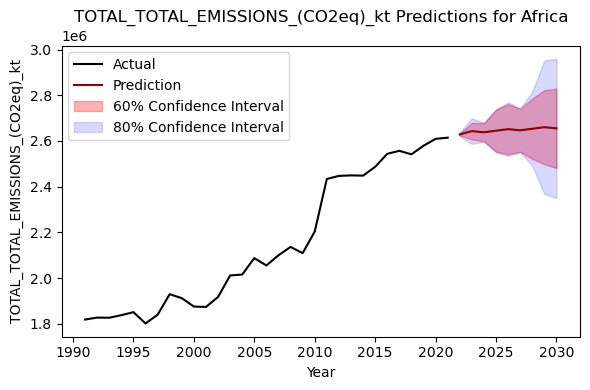

Plot saved as ../plots/forecasts/TOTAL_TOTAL_EMISSIONS_(CO2eq)_kt_predictions_Africa.png


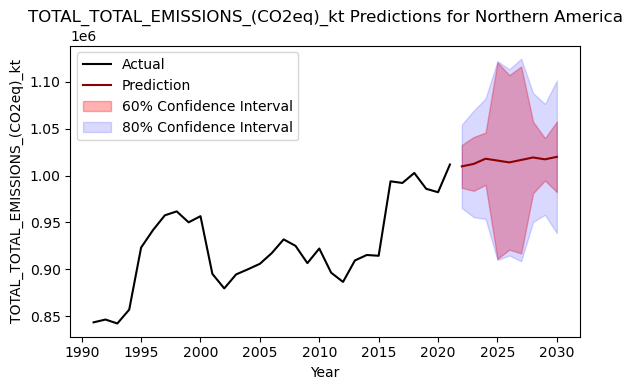

Plot saved as ../plots/forecasts/TOTAL_TOTAL_EMISSIONS_(CO2eq)_kt_predictions_Northern America.png


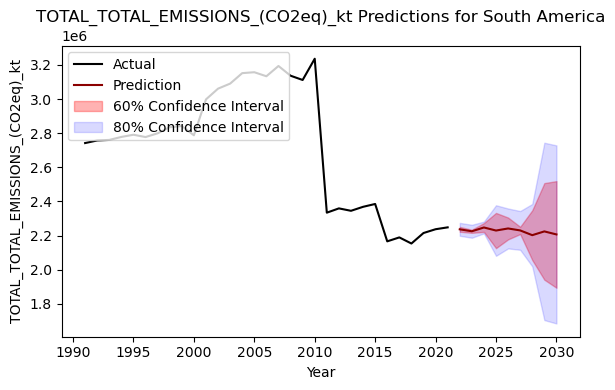

Plot saved as ../plots/forecasts/TOTAL_TOTAL_EMISSIONS_(CO2eq)_kt_predictions_South America.png


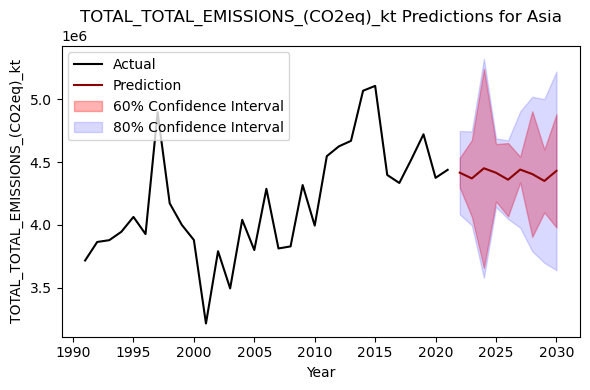

Plot saved as ../plots/forecasts/TOTAL_TOTAL_EMISSIONS_(CO2eq)_kt_predictions_Asia.png


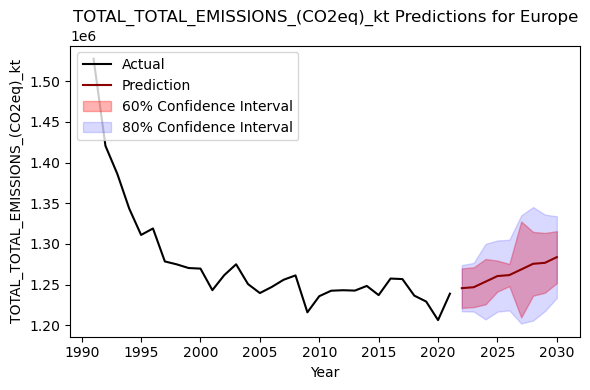

Plot saved as ../plots/forecasts/TOTAL_TOTAL_EMISSIONS_(CO2eq)_kt_predictions_Europe.png


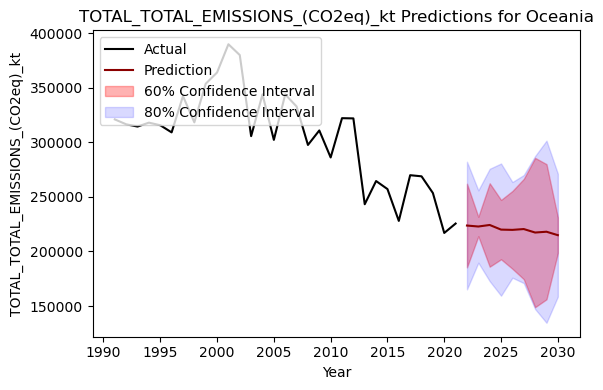

Plot saved as ../plots/forecasts/TOTAL_TOTAL_EMISSIONS_(CO2eq)_kt_predictions_Oceania.png


In [31]:
for region in full_train['unique_id'].unique():
    plot_data = full_train[full_train['unique_id'] == region]
    future_data = preds_2030[preds_2030['unique_id'] == region]

    plot_predictions_with_ci(plot_data, future_data, date_col='ds', actual_col='y', 
                                model='XGBRegressor', ci='60', ci2='80', target=target, region=region)

# Changes in emissions for the future as percentage

In [68]:
def percentage_change(df, x1, x2):
    # Filter the dataframe for the two specified years
    df_x1 = df[df['ds'] == x1].set_index('unique_id')['y']
    df_x2 = df[df['ds'] == x2].set_index('unique_id')['y']
    
    # Calculate the percentage change
    pct_change = ((df_x2 - df_x1) / df_x1) * 100
    
    # Print the results with values in gigatonnes and separators
    for unique_id in pct_change.index:
        y1_gigatonnes = df_x1[unique_id] / 1e6
        y2_gigatonnes = df_x2[unique_id] / 1e6
        change = pct_change[unique_id]
        print(f"{unique_id} Region:\n"
              f"  {x1} Value: {y1_gigatonnes:.2f} Gt of CO2\n"
              f"  {x2} Value: {y2_gigatonnes:.2f} Gt of CO2\n"
              f"  Percentage Change: {change:.2f}%\n"
              "-----------------------------------")

In [69]:
df_with_preds = pd.concat([full_train.iloc[:, :3], preds_2030.iloc[:, :3].rename(columns={"XGBRegressor": "y"})])

In [70]:
print(("Forecasted Percentage Change in Total Emissions from Agrifood Systems from 2021 to 2030").upper(), "\n")
percentage_change(df_with_preds, 2021, 2030)

FORECASTED PERCENTAGE CHANGE IN TOTAL EMISSIONS FROM AGRIFOOD SYSTEMS FROM 2021 TO 2030 

Africa Region:
  2021 Value: 2.61 Gt of CO2
  2030 Value: 2.66 Gt of CO2
  Percentage Change: 1.56%
-----------------------------------
Asia Region:
  2021 Value: 4.44 Gt of CO2
  2030 Value: 4.43 Gt of CO2
  Percentage Change: -0.19%
-----------------------------------
Europe Region:
  2021 Value: 1.24 Gt of CO2
  2030 Value: 1.28 Gt of CO2
  Percentage Change: 3.63%
-----------------------------------
Northern America Region:
  2021 Value: 1.01 Gt of CO2
  2030 Value: 1.02 Gt of CO2
  Percentage Change: 0.81%
-----------------------------------
Oceania Region:
  2021 Value: 0.23 Gt of CO2
  2030 Value: 0.21 Gt of CO2
  Percentage Change: -4.72%
-----------------------------------
South America Region:
  2021 Value: 2.25 Gt of CO2
  2030 Value: 2.21 Gt of CO2
  Percentage Change: -1.85%
-----------------------------------
World Region:
  2021 Value: 12.08 Gt of CO2
  2030 Value: 11.54 Gt of CO2
 